In [1]:
# ================================================
# 1. Importar librerías
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

In [2]:
# ================================================
# 2. Cargar datos (funciona CSV o XLSX)
# ================================================
# Cambia el archivo según el formato que tengas
file = "citybike_lima.csv"   # o "citybike_lima.xlsx"

if file.endswith(".csv"):
    df = pd.read_csv(file)
elif file.endswith(".xlsx"):
    df = pd.read_excel(file)

print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (19688, 17)


,scrape_timestamp,station_id,station_name,lat,lon,capacity,free_bikes,empty_slots,day_of_week,periodo_dia,weather_main,weather_desc,temp_C,wind_speed,clima_miraflores,temp_miraflores,in_miraflores
0,2025-10-01T11:34:22.005486-05:00,008a35afc6b4060be57b48bf90bec44c,18027 Ov. Julio Ramón Riveyro - Av. Pardo,-12.119013,-77.039928,14,8,6,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
1,2025-10-01T11:34:22.005486-05:00,03367da30caea302b11c838d8b98df55,18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora),-12.122125,-77.011506,16,8,8,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,False
2,2025-10-01T11:34:22.005486-05:00,06dd87a8b87232577015b1c9a4ba08ed,18024 Ov. Bolognesi - Ca. Madrid,-12.123368,-77.035637,14,3,11,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
3,2025-10-01T11:34:22.005486-05:00,0927eccbf04e2aadd179595c55c52bbe,18047 Malecón Cisneros - Ca. Trípoli,-12.125037,-77.037307,16,9,7,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
4,2025-10-01T11:34:22.005486-05:00,0ac132eb1a147b7b23a753185cbebd1d,18026 Malecón de la Marina - Parque Grau,-12.118497,-77.045048,20,11,9,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True


In [3]:
# ================================================
# 3. Revisión inicial
# ================================================
print("\nTipos de datos:")
print(df.dtypes)

print("\nNulos por columna:")
print(df.isnull().sum())

print("\nDuplicados:", df.duplicated().sum())




Tipos de datos:
scrape_timestamp     object
station_id           object
station_name         object
lat                 float64
lon                 float64
capacity              int64
free_bikes            int64
empty_slots           int64
day_of_week          object
periodo_dia          object
weather_main        float64
weather_desc        float64
temp_C              float64
wind_speed          float64
clima_miraflores     object
temp_miraflores     float64
in_miraflores          bool
dtype: object

Nulos por columna:
scrape_timestamp        0
station_id              0
station_name            0
lat                     0
lon                     0
capacity                0
free_bikes              0
empty_slots             0
day_of_week             0
periodo_dia             0
weather_main        19688
weather_desc        19688
temp_C                950
wind_speed          19688
clima_miraflores      950
temp_miraflores       950
in_miraflores           0
dtype: int64

Duplicados: 0


In [4]:
# Renombrar variables clave
df = df.rename(columns={
    "scrape_timestamp": "timestamp",
    "station_id": "id_estacion",
    "station_name": "nombre_estacion",
    "lat": "latitud",
    "lon": "longitud",
    "capacity": "capacidad",
    "free_bikes": "bicis_libres",
    "empty_slots": "espacios_vacios",
    "day_of_week": "dia_semana",
    "weather_main": "clima_general",
    "weather_desc": "clima_detalle",
    "temp_C": "temp_c",
    "wind_speed": "vel_viento",
    "clima_miraflores": "clima_miraflores",
    "temp_miraflores": "temp_miraflores",
    "in_miraflores": "en_miraflores"
})

# No eliminar filas si clima está vacío → solo no usar esas columnas
df = df.dropna(subset=["bicis_libres", "espacios_vacios", "capacidad"])
df["dia_semana"] = df["dia_semana"].astype(str).str.strip()

# tipos numéricos
for c in ['bicis_libres','capacidad','espacios_vacios','temp_c','lat','lon']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [5]:
# Timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
else:
    raise KeyError("⚠️ No se encontró la columna de timestamp")

df["hora"] = df["timestamp"].dt.hour
df["fecha"] = df["timestamp"].dt.date

# Si no hay día de semana explícito, derivarlo
if df["dia_semana"].nunique() <= 1:
    df["dia_semana"] = df["timestamp"].dt.day_name(locale="es_ES")
    df["dia_semana"] = df["dia_semana"].str.slice(0,3)  # Lun, Mar, etc.
    dias_orden = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
    df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=dias_orden, ordered=True)
# ocupacion safe
df['ocupacion'] = np.where(df['capacidad']>0, df['bicis_libres']/df['capacidad'], np.nan)
df['ocupacion'] = df['ocupacion'].clip(0,1)


In [6]:
# ================================================
# 7. Estadísticas descriptivas
# ================================================
print("\nResumen estadístico:")
print(df.describe(include="all"))



Resumen estadístico:
                                  timestamp                       id_estacion  \
count                                 19688                             19688   
unique                                  NaN                                51   
top                                     NaN  008a35afc6b4060be57b48bf90bec44c   
freq                                    NaN                               393   
mean    2025-10-06 04:39:43.478947328-05:00                               NaN   
min        2025-10-01 11:34:22.005486-05:00                               NaN   
25%     2025-10-03 17:18:56.110765056-05:00                               NaN   
50%     2025-10-06 03:30:09.141618944-05:00                               NaN   
75%     2025-10-08 15:24:03.930209024-05:00                               NaN   
max        2025-10-11 02:37:52.056674-05:00                               NaN   
std                                     NaN                               NaN   

     

In [7]:
# ================================================
# 8. Análisis por estación (versión corregida)
# ================================================

# Asegurar que los espacios vacíos estén bien definidos
df["espacios_vacios"] = df["capacidad"] - df["bicis_libres"]
df["espacios_vacios"] = df["espacios_vacios"].clip(lower=0)

# Análisis principal por estación
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=("nombre_estacion", "first"),
    obs=("id_estacion","count"),
    bicis_promedio=("bicis_libres","mean"),
    capacidad_promedio=("capacidad","mean"),
    ocupacion_promedio=("ocupacion","mean"),
    pct_vacia=("bicis_libres", lambda x: (x == 0).mean() * 100),
    pct_llena=("espacios_vacios", lambda x: (x == 0).mean() * 100)
).reset_index()

# Calcular hora pico según mayor ocupación promedio
hora_pico = (
    df.groupby(["id_estacion", "hora"])["ocupacion"]
    .mean()
    .reset_index()
    .sort_values(["id_estacion", "ocupacion"], ascending=[True, False])
    .groupby("id_estacion")
    .first()
    .reset_index()[["id_estacion", "hora"]]
    .rename(columns={"hora": "hora_pico"})
)

# Unir con el resumen principal
station_summary = station_summary.merge(hora_pico, on="id_estacion", how="left")

# Redondear resultados numéricos
cols_to_round = [
    "bicis_promedio",
    "capacidad_promedio",
    "ocupacion_promedio",
    "pct_vacia",
    "pct_llena"
]
station_summary[cols_to_round] = station_summary[cols_to_round].round(2)

# Ordenar por ocupación promedio (de mayor a menor)
station_summary = station_summary.sort_values("ocupacion_promedio", ascending=False)

# Mostrar los resultados principales
print(station_summary.head(10))


                         id_estacion  \
29  876923a9839232b31d01c19a6af87e6f   
42  c00d815ca6322144c5510d9f9e7121da   
41  bb40d8da8fed6afda3b2ff8f0c59e48d   
33  9652d392478ec6d31cb23d0a2d22aa30   
7   263e9a1c4f245c4070f8c85b88d0f10d   
25  7445571ff483b34f2e41c478e6d83588   
31  88a9e07a36d29cb5801f82cedd2534b4   
28  8301c7ecad3d99b5e04f03b87ffb8af4   
34  9b481ef2d05f69c2b56ac04ac189cc8d   
12  438d63a7c5cb69db70e9cd6665120d61   

                                      nombre_estacion  obs  bicis_promedio  \
29            18019 Boulevard Armendariz - Av. La Paz  393           13.65   
42          18011 Ca. GermánA.Goméz - Av.JoseR.Gastón  393           10.76   
41         18048 Av. Mariscal La Mar - Av. Santa Cruz  393            8.76   
33  18044 Estadio Manuel Bonilla - Malecón de la M...  393           15.22   
7          18021 Av. Armendariz -Av. Larco (Larcomar)  393           16.30   
25  18020 Mlcn. De la Reserva - Av. N. de Balboa (...  393           13.70   
31           

In [8]:
df["codigo_estacion"] = df["nombre_estacion"].str.extract(r"(\d{5})")
df[df["codigo_estacion"].isna()][["id_estacion","nombre_estacion"]]
df = df[df["codigo_estacion"] != "27042"]

df.head(60)

,timestamp,id_estacion,nombre_estacion,latitud,longitud,capacidad,bicis_libres,espacios_vacios,dia_semana,periodo_dia,...,clima_detalle,temp_c,vel_viento,clima_miraflores,temp_miraflores,en_miraflores,hora,fecha,ocupacion,codigo_estacion
0,2025-10-01 11:34:22.005486-05:00,008a35afc6b4060be57b48bf90bec44c,18027 Ov. Julio Ramón Riveyro - Av. Pardo,-12.119013,-77.039928,14,8,6,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.571429,18027
1,2025-10-01 11:34:22.005486-05:00,03367da30caea302b11c838d8b98df55,18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora),-12.122125,-77.011506,16,8,8,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,False,11,2025-10-01,0.500000,18009
2,2025-10-01 11:34:22.005486-05:00,06dd87a8b87232577015b1c9a4ba08ed,18024 Ov. Bolognesi - Ca. Madrid,-12.123368,-77.035637,14,3,11,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.214286,18024
3,2025-10-01 11:34:22.005486-05:00,0927eccbf04e2aadd179595c55c52bbe,18047 Malecón Cisneros - Ca. Trípoli,-12.125037,-77.037307,16,9,7,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.562500,18047
4,2025-10-01 11:34:22.005486-05:00,0ac132eb1a147b7b23a753185cbebd1d,18026 Malecón de la Marina - Parque Grau,-12.118497,-77.045048,20,11,9,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.550000,18026
5,2025-10-01 11:34:22.005486-05:00,11c5d99df877943158c7e7c693242e26,18022 Malecón de la Reserva - Malecón 28 de Julio,-12.128333,-77.035359,20,16,4,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.800000,18022
6,2025-10-01 11:34:22.005486-05:00,1ff7b00c8a2af2eeb129df70939eb20b,18034 Ca. Tacna - Av. A. Aramburú,-12.103375,-77.029535,16,12,4,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.750000,18034
7,2025-10-01 11:34:22.005486-05:00,263e9a1c4f245c4070f8c85b88d0f10d,18021 Av. Armendariz -Av. Larco (Larcomar),-12.131760,-77.029710,28,13,15,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.464286,18021
8,2025-10-01 11:34:22.005486-05:00,3ab2451c995f47035d2b14590753236a,18018 Av. Nuñez de Balboa - Av. Reducto,-12.129550,-77.024159,20,11,9,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.550000,18018
9,2025-10-01 11:34:22.005486-05:00,3c8e489aaccbcbbe87f59457fe1901d1,18016 Ca. Manco Capac - Av. Larco,-12.127882,-77.029429,16,7,9,Wednesday,mañana,...,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True,11,2025-10-01,0.437500,18016


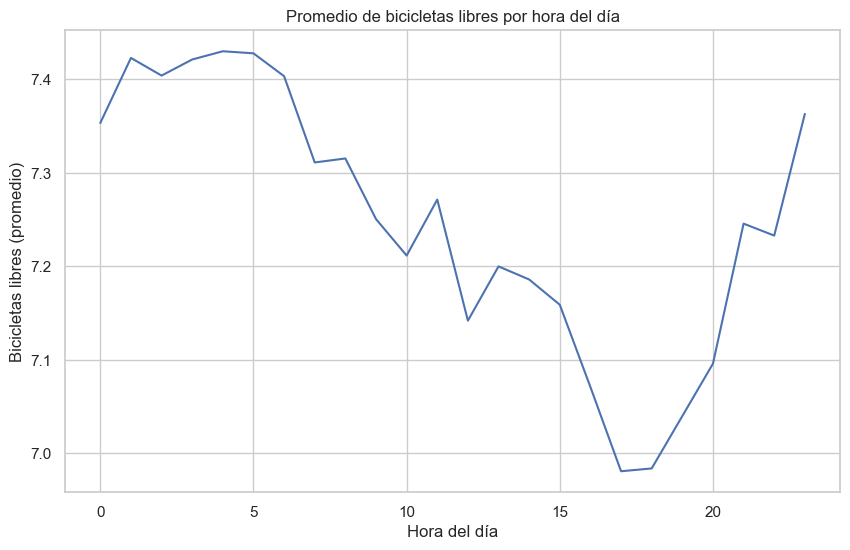

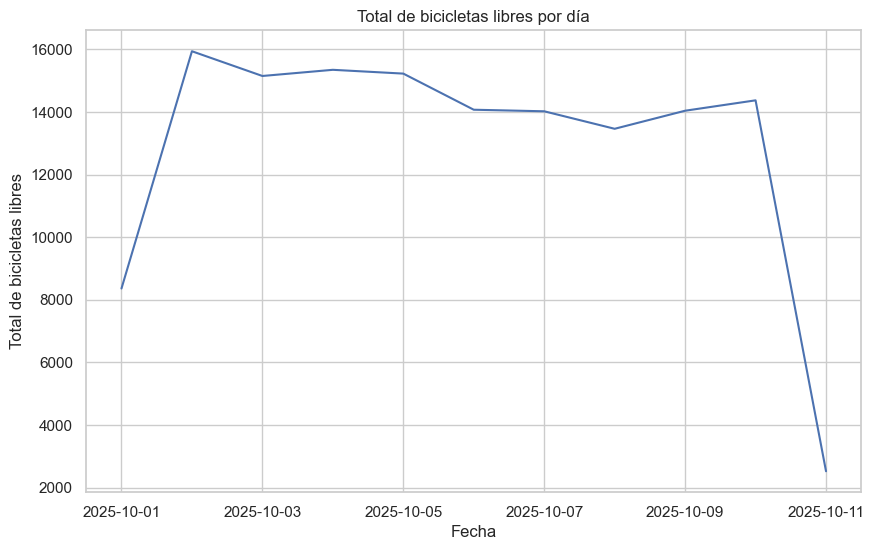

In [9]:
# ================================================
# 9. Series temporales
# ================================================
bikes_por_hora = df.groupby("hora")["bicis_libres"].mean()
bikes_por_hora.plot(title="Promedio de bicicletas libres por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Bicicletas libres (promedio)")
plt.show()

bikes_por_dia = df.groupby("fecha")["bicis_libres"].sum()
bikes_por_dia.plot(title="Total de bicicletas libres por día")
plt.xlabel("Fecha")
plt.ylabel("Total de bicicletas libres")
plt.show()




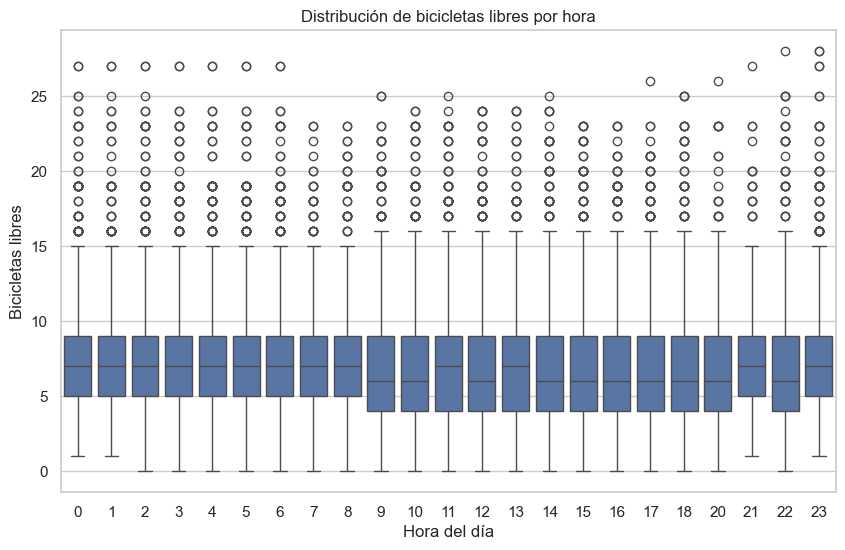

In [10]:
sns.boxplot(x="hora", y="bicis_libres", data=df)
plt.title("Distribución de bicicletas libres por hora")
plt.xlabel("Hora del día")
plt.ylabel("Bicicletas libres")
plt.show()


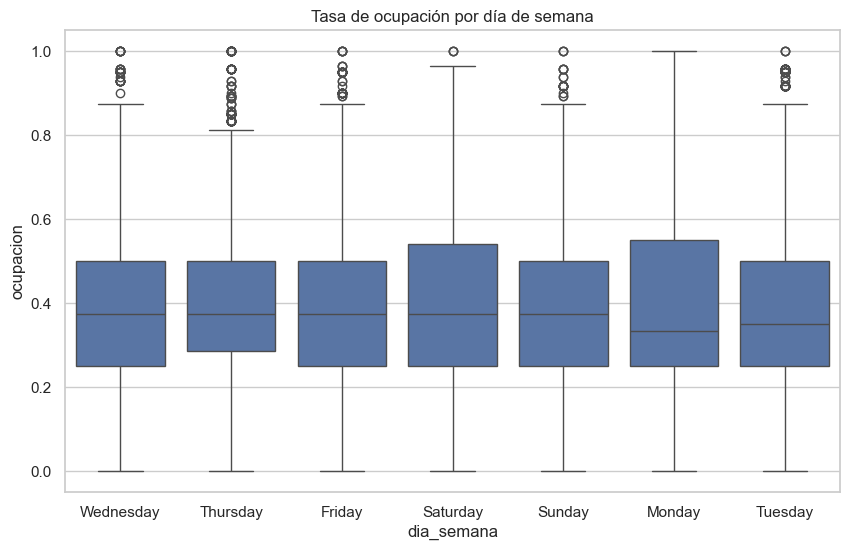

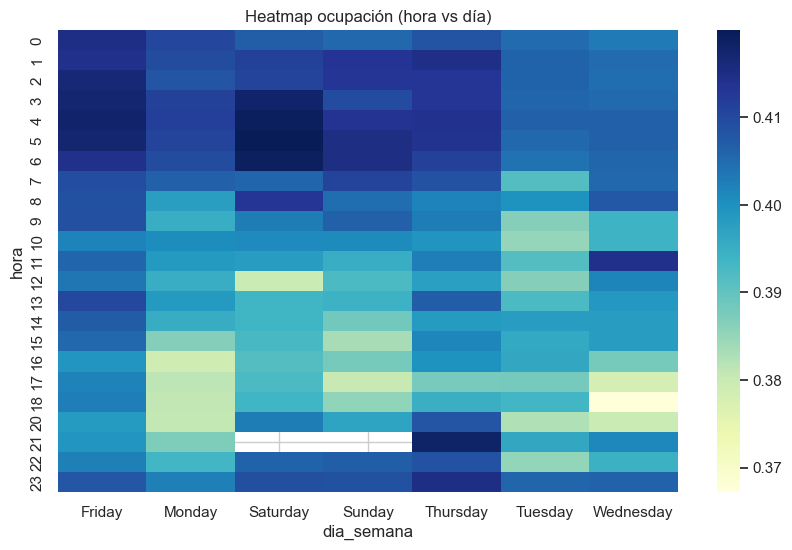

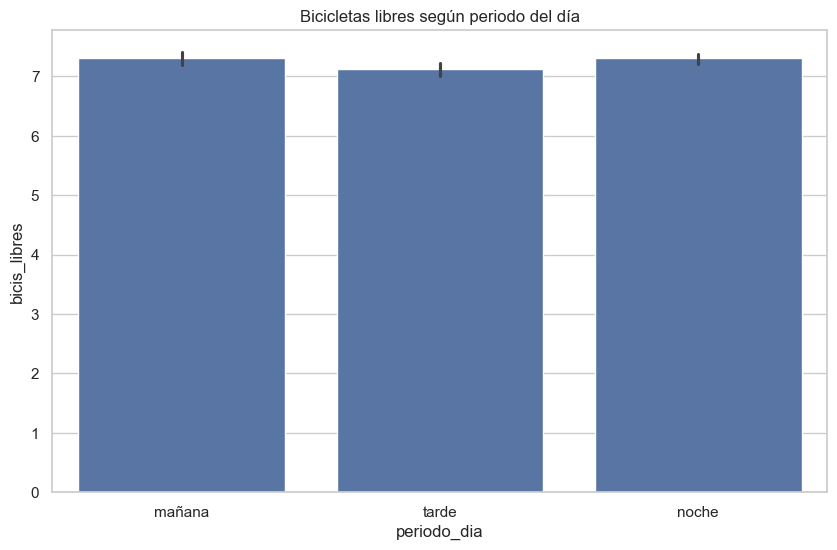

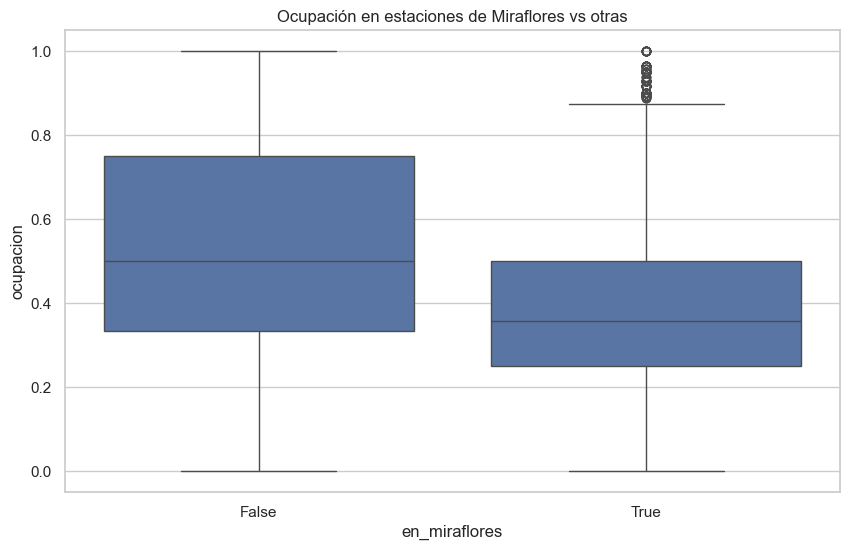

In [11]:

# ================================================
# 10. Distribuciones
# ================================================
# Evitar problemas si hay pocos días
# Boxplot por día de semana
if df["dia_semana"].nunique() > 1:
    sns.boxplot(x="dia_semana", y="ocupacion", data=df)
    plt.title("Tasa de ocupación por día de semana")
    plt.show()

# Heatmap hora vs día
pivot = df.pivot_table(index="hora", columns="dia_semana", values="ocupacion", aggfunc="mean")
if not pivot.empty:
    sns.heatmap(pivot, cmap="YlGnBu")
    plt.title("Heatmap ocupación (hora vs día)")
    plt.show()

# Bicicletas según clima (solo si hay datos útiles)
if df["clima_general"].nunique() > 1:
    sns.boxplot(x="clima_general", y="bicis_libres", data=df)
    plt.title("Bicicletas libres según clima")
    plt.xticks(rotation=45)
    plt.show()

# Periodo del día
sns.barplot(x="periodo_dia", y="bicis_libres", data=df, estimator=np.mean)
plt.title("Bicicletas libres según periodo del día")
plt.show()

# Miraflores vs resto
sns.boxplot(x="en_miraflores", y="ocupacion", data=df)
plt.title("Ocupación en estaciones de Miraflores vs otras")
plt.show()




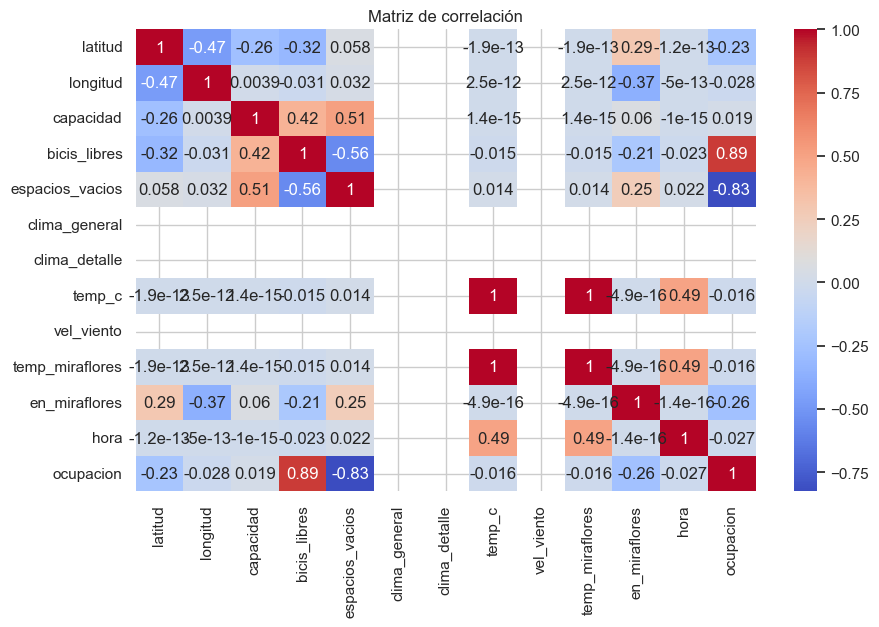

In [12]:


# ================================================
# 12. Matriz de correlación
# ================================================
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Matriz de correlación")
plt.show()




In [13]:
print(station_summary.columns )

Index(['id_estacion', 'nombre_estacion', 'obs', 'bicis_promedio',
       'capacidad_promedio', 'ocupacion_promedio', 'pct_vacia', 'pct_llena',
       'hora_pico'],
      dtype='object')



Distribución de estaciones por categoría de ocupación promedio:


ocup_cat_fixed
Baja     21
Media    28
Alta      2
Name: count, dtype: int64


Ejemplo de estaciones clasificadas:


,id_estacion,nombre_estacion,ocupacion_promedio,ocup_cat_fixed
29,876923a9839232b31d01c19a6af87e6f,18019 Boulevard Armendariz - Av. La Paz,0.68,Alta
42,c00d815ca6322144c5510d9f9e7121da,18011 Ca. GermánA.Goméz - Av.JoseR.Gastón,0.67,Alta
41,bb40d8da8fed6afda3b2ff8f0c59e48d,18048 Av. Mariscal La Mar - Av. Santa Cruz,0.63,Media
33,9652d392478ec6d31cb23d0a2d22aa30,18044 Estadio Manuel Bonilla - Malecón de la M...,0.63,Media
7,263e9a1c4f245c4070f8c85b88d0f10d,18021 Av. Armendariz -Av. Larco (Larcomar),0.58,Media
25,7445571ff483b34f2e41c478e6d83588,18020 Mlcn. De la Reserva - Av. N. de Balboa (...,0.57,Media
31,88a9e07a36d29cb5801f82cedd2534b4,18013 Ca. Tejada - Av. 28 de Julio,0.57,Media
28,8301c7ecad3d99b5e04f03b87ffb8af4,18023 Ca.BellavistaCdra.5,0.57,Media
34,9b481ef2d05f69c2b56ac04ac189cc8d,18049 Ca. Ignacio Merino - Av. La Mar,0.55,Media
12,438d63a7c5cb69db70e9cd6665120d61,18001 Ca. Oscar R. Benavides - Ca. Schell (Par...,0.51,Media


Conteo por categorías fijas (3 niveles):
ocup_cat_fixed
Baja     9070
Media    8115
Alta     2465
Name: count, dtype: int64


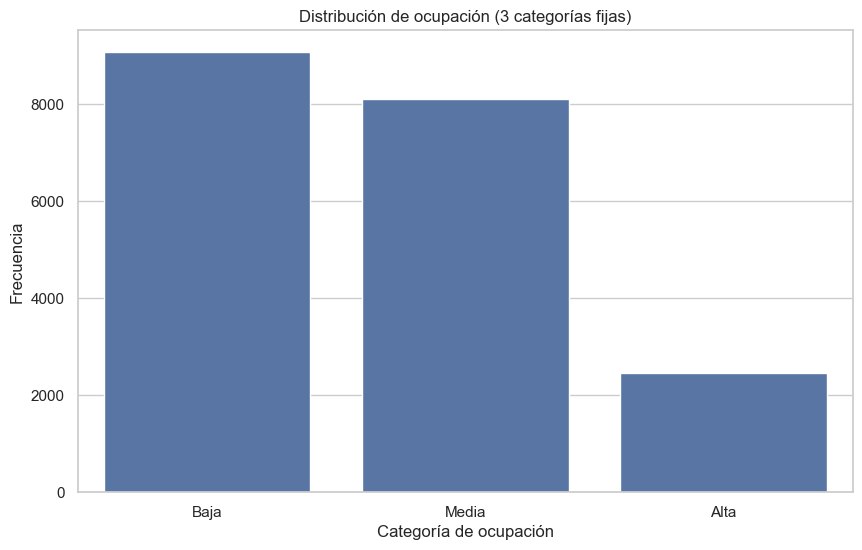

In [14]:
# ================================================
# Clasificación de ocupación (3 categorías)
# ================================================
bins = [0, 0.35, 0.65, 1]
labels = ['Baja', 'Media', 'Alta']
df['ocup_cat_fixed'] = pd.cut(df['ocupacion'], bins=bins, labels=labels, include_lowest=True)


# Agregar categorías a la tabla de resumen existente
station_summary['ocup_cat_fixed'] = pd.cut(
    station_summary['ocupacion_promedio'].fillna(0),
    bins=bins, labels=labels, include_lowest=True
)

# Mostrar resumen de cuántas estaciones hay por categoría
print("\nDistribución de estaciones por categoría de ocupación promedio:")
display(station_summary['ocup_cat_fixed'].value_counts().reindex(labels))

# Mostrar tabla de ejemplo con las 10 primeras estaciones clasificadas
print("\nEjemplo de estaciones clasificadas:")
display(station_summary[['id_estacion','nombre_estacion','ocupacion_promedio','ocup_cat_fixed']].head(10))

# Conteo de categorías
conteo_categorias = df['ocup_cat_fixed'].value_counts().reindex(labels)
print("Conteo por categorías fijas (3 niveles):")
print(conteo_categorias)

# Visualización
sns.countplot(x='ocup_cat_fixed', data=df, order=labels)
plt.title("Distribución de ocupación (3 categorías fijas)")
plt.xlabel("Categoría de ocupación")
plt.ylabel("Frecuencia")
plt.show()



Promedio de ocupación por hora y categoría fija:
ocup_cat_fixed      Baja     Media      Alta
hora                                        
0               0.249716  0.472959  0.777368
1               0.249610  0.469395  0.780948
2               0.248309  0.469866  0.777919
3               0.248626  0.471291  0.774899
4               0.246079  0.473665  0.776285
5               0.246654  0.474023  0.776285
6               0.243839  0.473597  0.775943
7               0.239939  0.474596  0.769150
8               0.239971  0.476160  0.766924
9               0.231221  0.479768  0.765862
10              0.231176  0.478177  0.767316
11              0.232400  0.474326  0.764456
12              0.222400  0.473223  0.765478
13              0.235945  0.475704  0.773803
14              0.230690  0.471437  0.780777
15              0.233052  0.468623  0.775586
16              0.229269  0.474200  0.773208
17              0.227977  0.479475  0.773889
18              0.224978  0.480918  0.787629
19    

C:\Users\curay\AppData\Local\Temp\ipykernel_16944\3438450333.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ocup_cat_fixed', 'hora'])


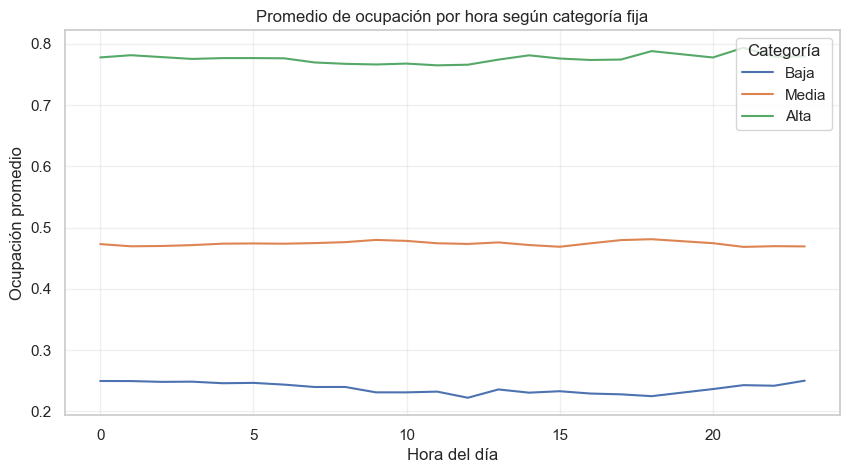

In [15]:
# ================================================
# Promedio de ocupación por hora y categoría fija
# ================================================
# Asegurar orden de categorías
labels = ['Baja', 'Media', 'Alta']
df['ocup_cat_fixed'] = pd.Categorical(df['ocup_cat_fixed'], categories=labels, ordered=True)

# Agrupación
agg_hour = (
    df.dropna(subset=['ocup_cat_fixed', 'ocupacion'])
      .groupby(['ocup_cat_fixed', 'hora'])
      .agg(mean_ocup=('ocupacion', 'mean'),
           n_obs=('ocupacion', 'count'))
      .reset_index()
)

# Pivot (hora vs categoría)
pivot_hour = agg_hour.pivot(index='hora', columns='ocup_cat_fixed', values='mean_ocup')

# Rellenar horas faltantes (si alguna no aparece)
pivot_hour = pivot_hour.reindex(range(24))
pivot_hour = pivot_hour.interpolate(method='linear')

# Guardar (opcional)
pivot_hour.to_csv('pivot_hour_mean_ocup.csv', index=True)

# Mostrar primeras filas
print("Promedio de ocupación por hora y categoría fija:")
print(pivot_hour.head(24))

# Visualización (líneas por categoría)
pivot_hour.plot(figsize=(10,5))
plt.title("Promedio de ocupación por hora según categoría fija")
plt.xlabel("Hora del día")
plt.ylabel("Ocupación promedio")
plt.legend(title="Categoría")
plt.grid(True, alpha=0.3)
plt.show()


In [16]:
# ================================================
# Clasificación dinámica de ocupación
# ================================================


# 1️⃣ Definir bins y labels si no existen
if 'bins' not in globals() or 'labels' not in globals():
    bins = [0, 0.35, 0.65, 1]
    labels = ['Baja', 'Media', 'Alta']
    print("Usando bins/labels por defecto:", bins, labels)
else:
    print("Usando bins/labels existentes.")

# 2️⃣ Eliminar columnas duplicadas si existen
for col in ['categoria_ocupacion', 'ocupacion_promedio', 'categoria_ocupacion_promedio']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"🧹 Columna duplicada '{col}' eliminada del df.")

# 3️⃣ Crear categoría de ocupación instantánea
df['categoria_ocupacion'] = pd.cut(
    df['ocupacion'].fillna(0),
    bins=bins,
    labels=labels,
    include_lowest=True
)
print("✅ Columna 'categoria_ocupacion' creada en base a ocupación instantánea.")
print(df[['id_estacion', 'ocupacion', 'categoria_ocupacion']].head())

# ------------------------------------------------
# 4️⃣ Agregar categoría basada en ocupacion_promedio
# ------------------------------------------------

# Verificar que station_summary exista
if 'station_summary' not in globals():
    raise RuntimeError("No existe 'station_summary'. Ejecuta primero el bloque que lo crea.")

# Crear columna de categoría promedio
station_summary['categoria_ocupacion_promedio'] = pd.cut(
    station_summary['ocupacion_promedio'].fillna(0),
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Asegurarse que 'id_estacion' sea string para merge
df['id_estacion'] = df['id_estacion'].astype(str)
station_summary['id_estacion'] = station_summary['id_estacion'].astype(str)

# Merge para traer ocupacion_promedio y categoria al df
df = df.merge(
    station_summary[['id_estacion', 'ocupacion_promedio', 'categoria_ocupacion_promedio']],
    on='id_estacion',
    how='left',
    validate='many_to_one'
)

# ------------------------------------------------
# 5️⃣ Verificaciones rápidas
# ------------------------------------------------
print("\n✅ Dimensiones después del merge:", df.shape)
print("Total filas con categoría promedio asignada:", df['categoria_ocupacion_promedio'].notna().sum(), "/", len(df))
print("\nConteo por categoría (en df):")
print(df['categoria_ocupacion_promedio'].value_counts(dropna=False))

# 6️⃣ Mostrar ejemplo comparando ocupaciones
print("\nEjemplo (primeras filas comparando ocupaciones):")
display(df[['id_estacion', 'ocupacion', 'ocupacion_promedio', 
            'categoria_ocupacion', 'categoria_ocupacion_promedio']].head(10))



Usando bins/labels existentes.
✅ Columna 'categoria_ocupacion' creada en base a ocupación instantánea.
                        id_estacion  ocupacion categoria_ocupacion
0  008a35afc6b4060be57b48bf90bec44c   0.571429               Media
1  03367da30caea302b11c838d8b98df55   0.500000               Media
2  06dd87a8b87232577015b1c9a4ba08ed   0.214286                Baja
3  0927eccbf04e2aadd179595c55c52bbe   0.562500               Media
4  0ac132eb1a147b7b23a753185cbebd1d   0.550000               Media

✅ Dimensiones después del merge: (19650, 25)
Total filas con categoría promedio asignada: 19650 / 19650

Conteo por categoría (en df):
categoria_ocupacion_promedio
Media    11004
Baja      7860
Alta       786
Name: count, dtype: int64

Ejemplo (primeras filas comparando ocupaciones):


,id_estacion,ocupacion,ocupacion_promedio,categoria_ocupacion,categoria_ocupacion_promedio
0,008a35afc6b4060be57b48bf90bec44c,0.571429,0.45,Media,Media
1,03367da30caea302b11c838d8b98df55,0.500000,0.30,Media,Baja
2,06dd87a8b87232577015b1c9a4ba08ed,0.214286,0.36,Baja,Media
3,0927eccbf04e2aadd179595c55c52bbe,0.562500,0.38,Media,Media
4,0ac132eb1a147b7b23a753185cbebd1d,0.550000,0.38,Media,Media
5,11c5d99df877943158c7e7c693242e26,0.800000,0.42,Alta,Media
6,1ff7b00c8a2af2eeb129df70939eb20b,0.750000,0.39,Alta,Media
7,263e9a1c4f245c4070f8c85b88d0f10d,0.464286,0.58,Media,Media
8,3ab2451c995f47035d2b14590753236a,0.550000,0.39,Media,Media
9,3c8e489aaccbcbbe87f59457fe1901d1,0.437500,0.40,Media,Media


In [17]:
df.head(5)

,timestamp,id_estacion,nombre_estacion,latitud,longitud,capacidad,bicis_libres,espacios_vacios,dia_semana,periodo_dia,...,temp_miraflores,en_miraflores,hora,fecha,ocupacion,codigo_estacion,ocup_cat_fixed,categoria_ocupacion,ocupacion_promedio,categoria_ocupacion_promedio
0,2025-10-01 11:34:22.005486-05:00,008a35afc6b4060be57b48bf90bec44c,18027 Ov. Julio Ramón Riveyro - Av. Pardo,-12.119013,-77.039928,14,8,6,Wednesday,mañana,...,19.0,True,11,2025-10-01,0.571429,18027,Media,Media,0.45,Media
1,2025-10-01 11:34:22.005486-05:00,03367da30caea302b11c838d8b98df55,18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora),-12.122125,-77.011506,16,8,8,Wednesday,mañana,...,19.0,False,11,2025-10-01,0.500000,18009,Media,Media,0.30,Baja
2,2025-10-01 11:34:22.005486-05:00,06dd87a8b87232577015b1c9a4ba08ed,18024 Ov. Bolognesi - Ca. Madrid,-12.123368,-77.035637,14,3,11,Wednesday,mañana,...,19.0,True,11,2025-10-01,0.214286,18024,Baja,Baja,0.36,Media
3,2025-10-01 11:34:22.005486-05:00,0927eccbf04e2aadd179595c55c52bbe,18047 Malecón Cisneros - Ca. Trípoli,-12.125037,-77.037307,16,9,7,Wednesday,mañana,...,19.0,True,11,2025-10-01,0.562500,18047,Media,Media,0.38,Media
4,2025-10-01 11:34:22.005486-05:00,0ac132eb1a147b7b23a753185cbebd1d,18026 Malecón de la Marina - Parque Grau,-12.118497,-77.045048,20,11,9,Wednesday,mañana,...,19.0,True,11,2025-10-01,0.550000,18026,Media,Media,0.38,Media


=== Mapas de calor: hora vs ocupación promedio (escala ajustada por categoría) ===


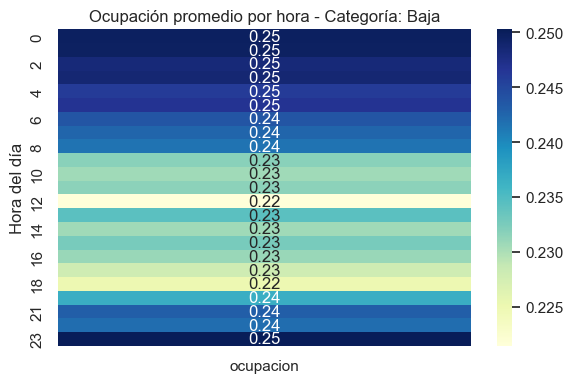

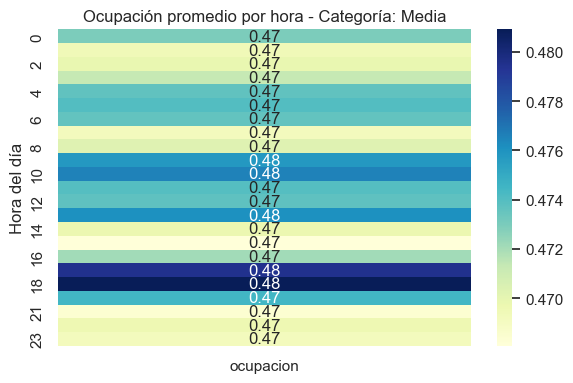

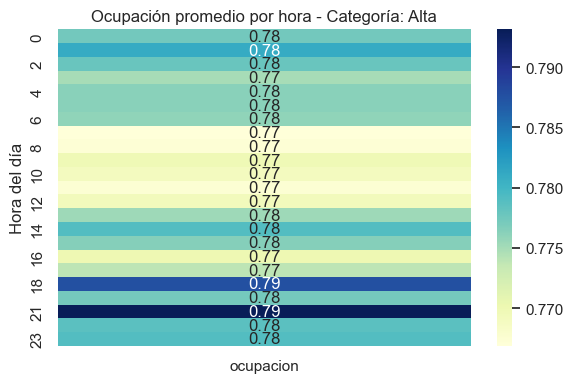


=== Mapas de calor: temperatura vs ocupación promedio (escala ajustada por categoría) ===


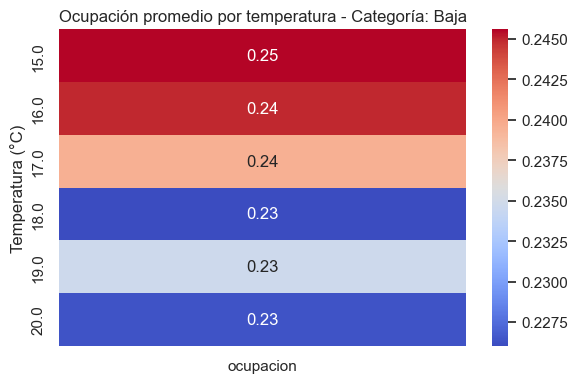

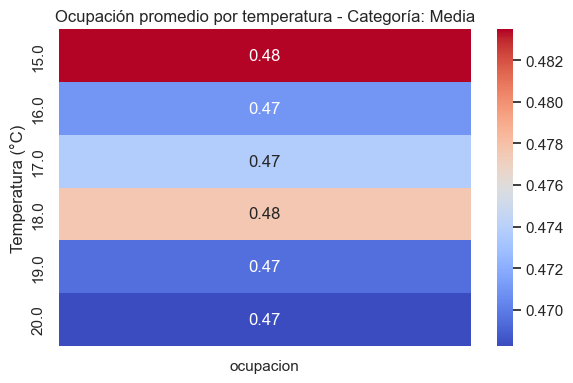

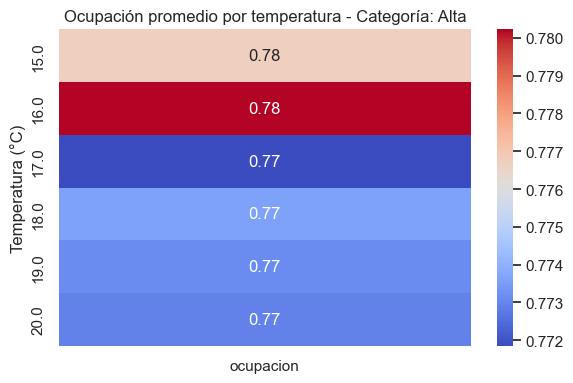

In [18]:
# ================================================
# 11. Mapas de calor por categoría de ocupación (con escala ajustada por categoría)
# ================================================


# Aseguramos tipos correctos
df["hora"] = df["hora"].astype(int)
df["temp_c_redondeada"] = df["temp_c"].round()

# Filtrar datos válidos
df_filtrado = df.dropna(subset=["ocupacion", "hora", "temp_c_redondeada", "categoria_ocupacion"])

# Categorías presentes realmente
categorias = [c for c in labels if c in df_filtrado["categoria_ocupacion"].unique()]

# --- Mapas de calor por hora ---
print("=== Mapas de calor: hora vs ocupación promedio (escala ajustada por categoría) ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    if subset.empty:
        print(f"⚠️ Sin datos para la categoría {cat}, se omite el mapa.")
        continue

    pivot_hora = subset.pivot_table(index="hora", values="ocupacion", aggfunc="mean")

    # Escala específica de color para esta categoría
    vmin = pivot_hora["ocupacion"].min()
    vmax = pivot_hora["ocupacion"].max()

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        pivot_hora,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax
    )
    plt.title(f"Ocupación promedio por hora - Categoría: {cat}")
    plt.ylabel("Hora del día")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

# --- Mapas de calor por temperatura ---
print("\n=== Mapas de calor: temperatura vs ocupación promedio (escala ajustada por categoría) ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    if subset.empty:
        print(f"⚠️ Sin datos para la categoría {cat}, se omite el mapa.")
        continue

    pivot_temp = subset.pivot_table(index="temp_c_redondeada", values="ocupacion", aggfunc="mean").sort_index()

    # Escala específica para la categoría
    vmin = pivot_temp["ocupacion"].min()
    vmax = pivot_temp["ocupacion"].max()

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        pivot_temp,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax
    )
    plt.title(f"Ocupación promedio por temperatura - Categoría: {cat}")
    plt.ylabel("Temperatura (°C)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()



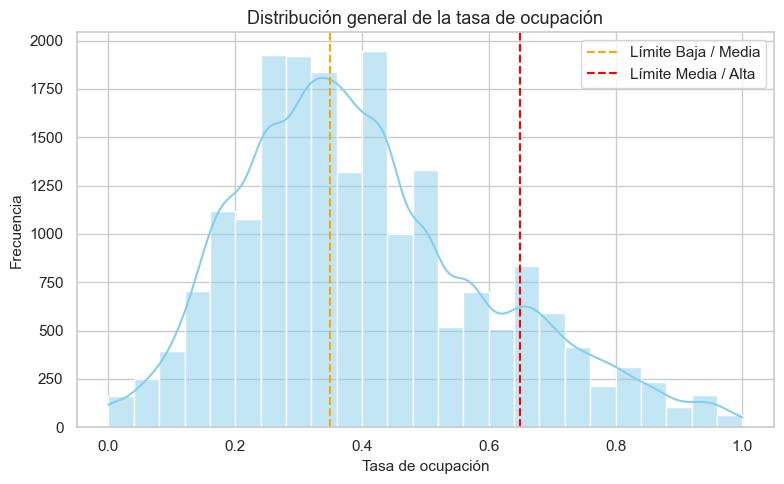

In [19]:

# ==========================================================
# VISUALIZACIONES
# ==========================================================

# --- 1️⃣ Histograma general de la tasa de ocupación ---
plt.figure(figsize=(8,5))
sns.histplot(df['ocupacion'], bins=25, kde=True, color='skyblue', edgecolor='white')

# Líneas verticales según categorías reales
plt.axvline(0.35, color='orange', linestyle='--', label='Límite Baja / Media')
plt.axvline(0.65, color='red', linestyle='--', label='Límite Media / Alta')

plt.title("Distribución general de la tasa de ocupación", fontsize=13)
plt.xlabel("Tasa de ocupación", fontsize=11)
plt.ylabel("Frecuencia", fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()





C:\Users\curay\AppData\Local\Temp\ipykernel_16944\4142597933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")


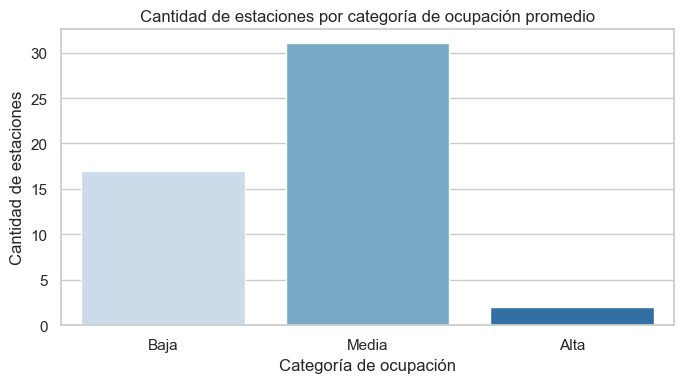

C:\Users\curay\AppData\Local\Temp\ipykernel_16944\4142597933.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


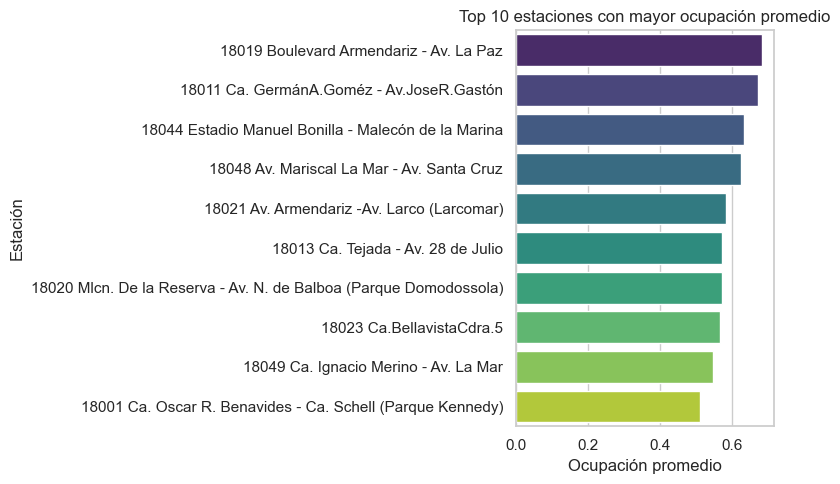

In [20]:
# ==========================================================
# OCUPACIÓN PROMEDIO POR ESTACIÓN Y CATEGORIZACIÓN
# ==========================================================

# Calcular ocupación promedio por estación
station_summary = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', 'first'),
    mean_ocupacion=('ocupacion', 'mean'),
    obs=('id_estacion', 'count')
).reset_index()

# Clasificar cada estación según su ocupación promedio
bins = [0, 0.35, 0.65, 1]
labels = ['Baja', 'Media', 'Alta']
station_summary['ocup_cat_fixed'] = pd.cut(
    station_summary['mean_ocupacion'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# ==========================================================
# VISUALIZACIÓN POR ESTACIONES
# ==========================================================

# --- 1️⃣ Conteo de estaciones por categoría ---
conteo_estaciones = station_summary['ocup_cat_fixed'].value_counts().reindex(labels)

plt.figure(figsize=(7,4))
sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")
plt.title("Cantidad de estaciones por categoría de ocupación promedio")
plt.xlabel("Categoría de ocupación")
plt.ylabel("Cantidad de estaciones")
plt.tight_layout()
plt.show()

# --- 2️⃣ Ranking de estaciones con mayor ocupación promedio ---
top_estaciones = station_summary.sort_values('mean_ocupacion', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion',
    y='nombre_estacion',
    data=top_estaciones,
    palette="viridis"
)
plt.title("Top 10 estaciones con mayor ocupación promedio")
plt.xlabel("Ocupación promedio")
plt.ylabel("Estación")
plt.tight_layout()
plt.show()


In [21]:
print(station_summary.columns )

Index(['id_estacion', 'nombre_estacion', 'mean_ocupacion', 'obs',
       'ocup_cat_fixed'],
      dtype='object')


C:\Users\curay\AppData\Local\Temp\ipykernel_16944\330587728.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


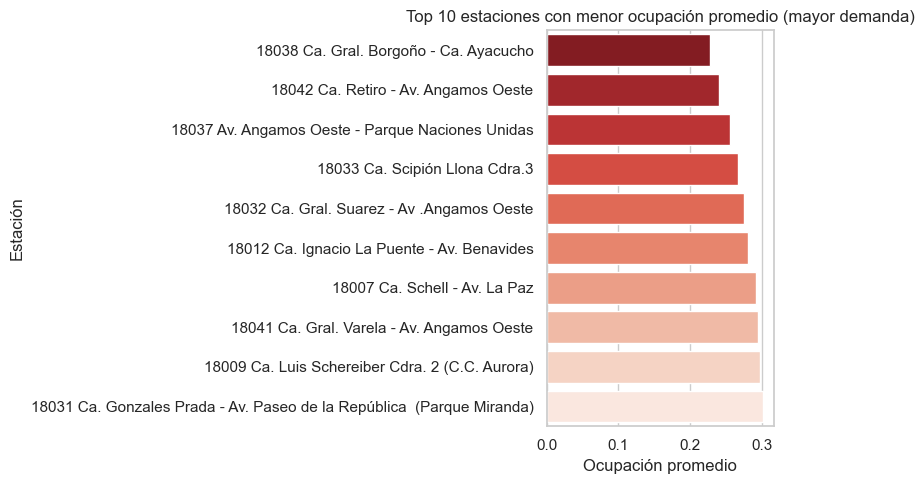

C:\Users\curay\AppData\Local\Temp\ipykernel_16944\330587728.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ocup_hora = df_high_demand.groupby(


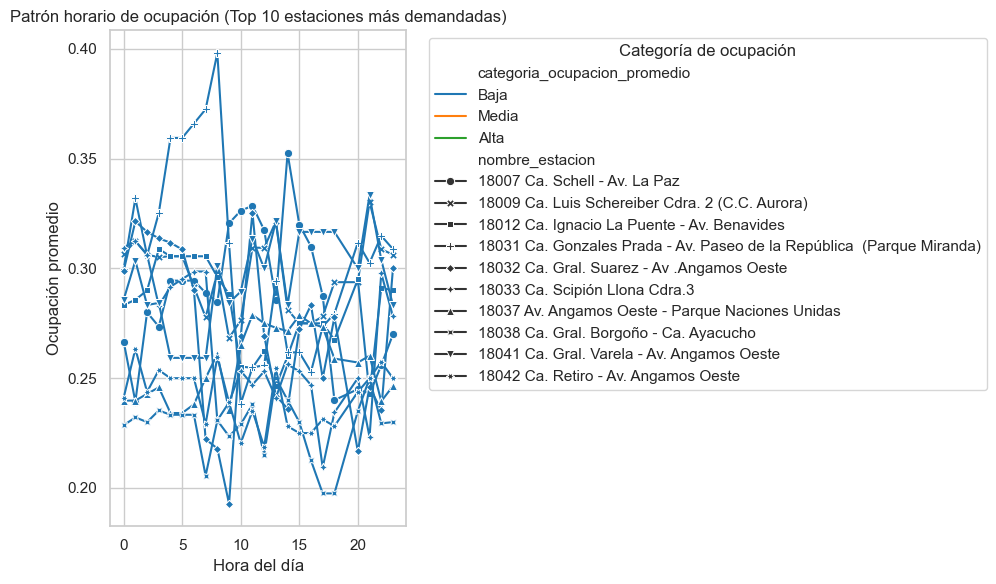

In [22]:
# ==========================================================
# 1️⃣ Estaciones con menor ocupación promedio (alta demanda)
# ==========================================================
bottom_estaciones = station_summary.sort_values('mean_ocupacion', ascending=True).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion',
    y='nombre_estacion',
    data=bottom_estaciones,
    palette="Reds_r"  # colores invertidos: rojo = más vacía
)
plt.title("Top 10 estaciones con menor ocupación promedio (mayor demanda)")
plt.xlabel("Ocupación promedio")
plt.ylabel("Estación")
plt.tight_layout()
plt.show()

# ==========================================================
# 2️⃣ Ocupación por hora para estaciones de alta demanda
# ==========================================================
# Filtramos el dataset original solo para esas estaciones
df_high_demand = df[df['id_estacion'].isin(bottom_estaciones['id_estacion'])].copy()

# Aseguramos tipo entero en la columna hora
df_high_demand['hora'] = df_high_demand['hora'].astype(int)

# Agrupación por hora y estación usando categoría desde df
ocup_hora = df_high_demand.groupby(
    ['nombre_estacion','hora','categoria_ocupacion_promedio']
).agg(
    ocupacion_promedio=('ocupacion','mean')
).reset_index()

# Lineplot con categoría como hue
plt.figure(figsize=(10,6))
sns.lineplot(
    data=ocup_hora, 
    x='hora', 
    y='ocupacion_promedio', 
    hue='categoria_ocupacion_promedio', 
    style='nombre_estacion',  # opcional: distingue estaciones por estilo de línea
    markers=True,
    dashes=False,
    palette="tab10"
)
plt.title("Patrón horario de ocupación (Top 10 estaciones más demandadas)")
plt.xlabel("Hora del día")
plt.ylabel("Ocupación promedio")
plt.legend(title="Categoría de ocupación", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Cantidad total de filas: 19650
Cantidad con avenida asignada: 18864
Cantidad sin avenida asignada: 786

Ejemplo de avenidas detectadas:
['Av. Pardo' 'Ca. Luis Schereiber Cdra' 'Ca. Madrid' 'Malecón Cisneros'
 'Malecón de la Marina' 'Malecón de la Reserva' 'Ca. Tacna'
 'Av. Armendariz' 'Av. Nuñez de Balboa' 'Ca. Manco Capac']


C:\Users\curay\AppData\Local\Temp\ipykernel_16944\317763700.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


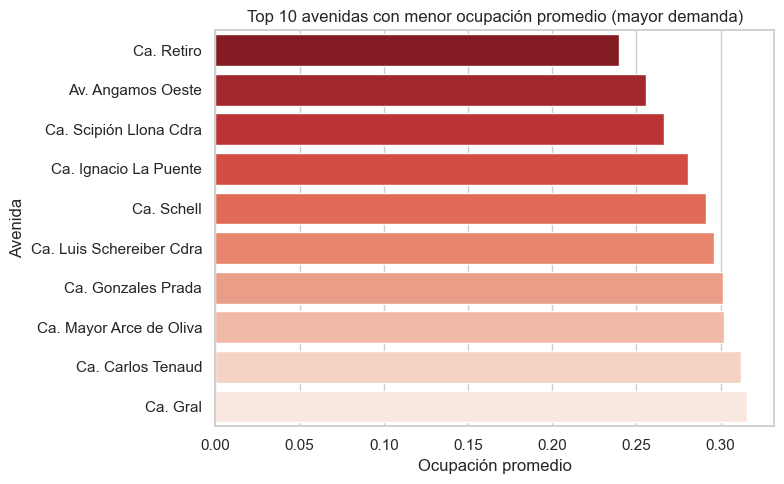

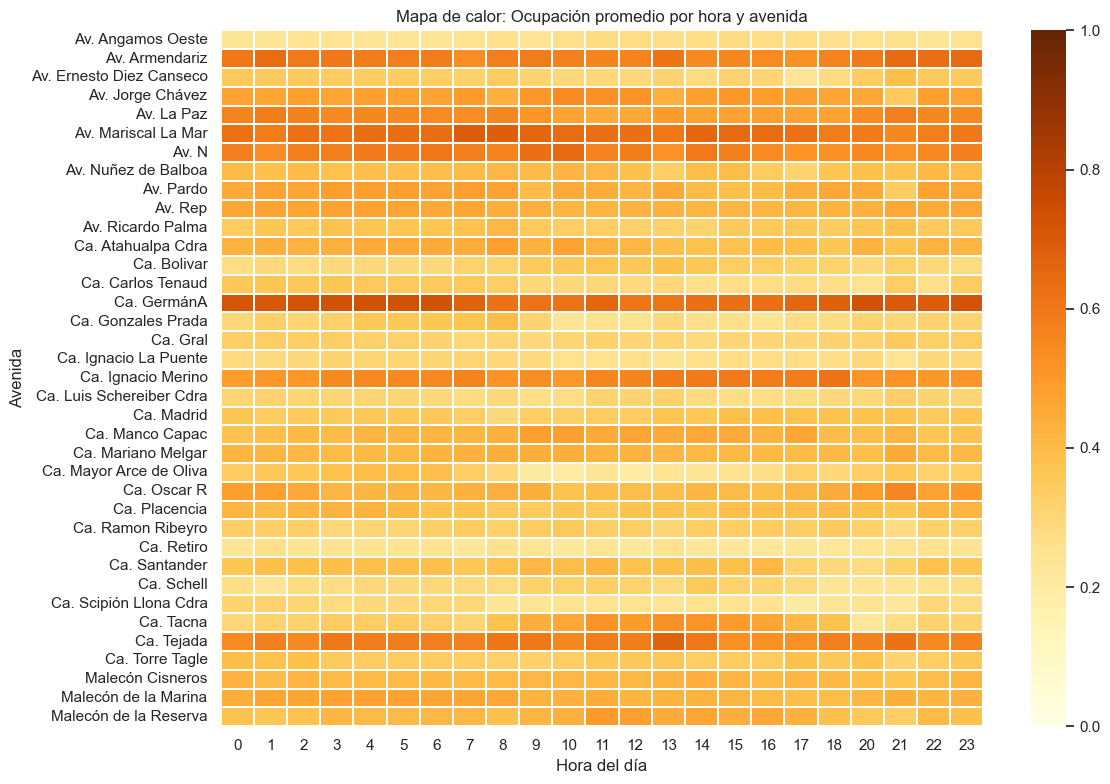

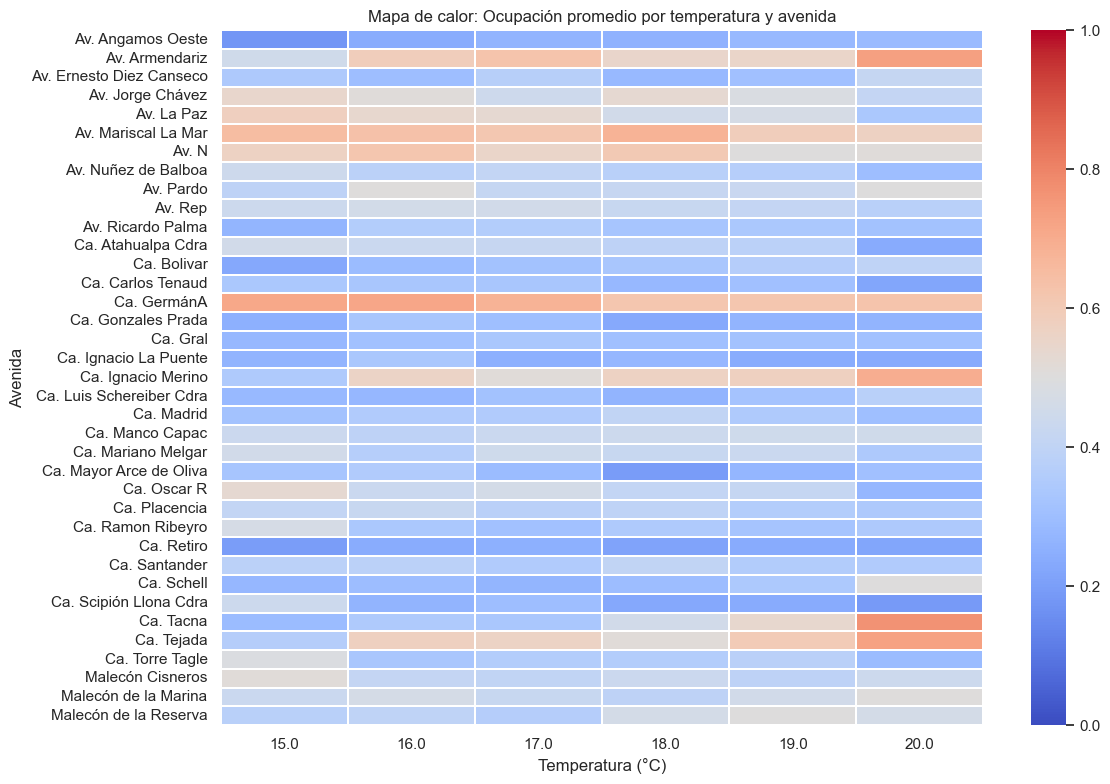

In [23]:
# ===============================================================
# 🚲 ANÁLISIS DE OCUPACIÓN PROMEDIO POR AVENIDA - CITYBIKE (versión ajustada)
# ===============================================================


# --- 1️⃣ Filtrado básico de estaciones válidas ---
min_obs = 40  # mínimo de observaciones por estación
station_summary = df.groupby('id_estacion')['ocupacion'].agg(['count', 'mean']).reset_index()
station_summary.rename(columns={'count': 'obs', 'mean': 'ocup_promedio'}, inplace=True)

good_stations = station_summary[station_summary['obs'] >= min_obs]['id_estacion']
df_filtered = df[df['id_estacion'].isin(good_stations)].copy()

# --- 2️⃣ Detectar avenida a partir del nombre de estación ---
# Regex actualizado para mayúsculas/minúsculas y palabras clave
df_filtered['avenida'] = df_filtered['nombre_estacion'].str.extract(
    r'(?i)((?:Av\.|Avenida|Ca\.|Calle|Malecón|Parque)\s+[A-Za-zÁÉÍÓÚáéíóúñÑ\s]+)'
)
df_filtered['avenida'] = df_filtered['avenida'].str.strip()

print("Cantidad total de filas:", len(df_filtered))
print("Cantidad con avenida asignada:", df_filtered['avenida'].notna().sum())
print("Cantidad sin avenida asignada:", df_filtered['avenida'].isna().sum())
print("\nEjemplo de avenidas detectadas:")
print(df_filtered['avenida'].dropna().unique()[:10])

# --- 3️⃣ Eliminar filas sin avenida ---
df_filtered = df_filtered.dropna(subset=['avenida'])

# --- 4️⃣ Promedio de ocupación por avenida ---
avenida_stats = (
    df_filtered.groupby('avenida')['ocupacion']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
    .rename(columns={'ocupacion': 'ocupacion_promedio'})
)

# --- 5️⃣ Top 10 de menor ocupación promedio (mayor demanda) ---
top10_baja_ocup = avenida_stats.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10_baja_ocup,
    x='ocupacion_promedio',
    y='avenida',
    palette='Reds_r'
)
plt.title("Top 10 avenidas con menor ocupación promedio (mayor demanda)")
plt.xlabel("Ocupación promedio")
plt.ylabel("Avenida")
plt.tight_layout()
plt.show()

# --- 6️⃣ Mapa de calor: ocupación promedio por hora y avenida ---
pivot_hora = df_filtered.pivot_table(
    index='avenida',
    columns='hora',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_hora.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_hora, cmap='YlOrBr', linewidths=0.3, vmin=0, vmax=1)
    plt.title("Mapa de calor: Ocupación promedio por hora y avenida")
    plt.xlabel("Hora del día")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para el mapa de calor por hora.")

# --- 7️⃣ Mapa de calor: ocupación promedio por temperatura y avenida ---
df_filtered['temp_redondeada'] = df_filtered['temp_c'].round()
pivot_temp = df_filtered.pivot_table(
    index='avenida',
    columns='temp_redondeada',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_temp.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_temp, cmap='coolwarm', linewidths=0.3, vmin=0, vmax=1)
    plt.title("Mapa de calor: Ocupación promedio por temperatura y avenida")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para el mapa de calor por temperatura.")



In [24]:
# ===============================================================
# 🌍 MAPAS DE OCUPACIÓN PROMEDIO CITYBIKE (por estación y avenida)
# ===============================================================

import folium
from folium.plugins import HeatMap

# --- 1️⃣ Promedio por estación a partir del df general ---
# Tomamos la primera fila por estación para lat/lon y promedio
df_estaciones = df.groupby(
    ['id_estacion', 'nombre_estacion', 'latitud', 'longitud']
).agg(
    ocupacion_promedio=('ocupacion_promedio', 'first'),
    categoria_promedio=('categoria_ocupacion_promedio', 'first')
).reset_index()

print("✅ Filas válidas para el mapa:", len(df_estaciones))
print("📊 Ejemplo de datos promediados:")
print(df_estaciones.head())

# --- 2️⃣ Crear mapa base centrado en Miraflores ---
m_estaciones = folium.Map(location=[-12.121, -77.03], zoom_start=14)

# --- 3️⃣ Añadir puntos al mapa con colores según categoría ---
color_map = {
    'Baja': 'red',
    'Media': 'orange',
    'Alta': 'green'
}

for _, row in df_estaciones.iterrows():
    color = color_map.get(row['categoria_promedio'], 'blue')  # azul por defecto si no hay categoría
    popup_text = f"""
    <b>{row['nombre_estacion']}</b><br>
    Ocupación promedio: {row['ocupacion_promedio']:.2f}<br>
    Categoría: {row['categoria_promedio']}
    """
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=7,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(m_estaciones)

# --- 4️⃣ Guardar mapa de puntos ---
m_estaciones.save("mapa_ocupacion_estaciones.html")
print("🌍 Mapa de puntos guardado como 'mapa_ocupacion_estaciones.html'.")

# ===============================================================
# 🔥 MAPA DE CALOR - OCUPACIÓN PROMEDIO
# ===============================================================

print("\nGenerando mapa de calor...")

# Crear lista de [latitud, longitud, ocupación promedio]
heat_data = df_estaciones[['latitud', 'longitud', 'ocupacion_promedio']].values.tolist()

# Mapa base
m_heat = folium.Map(location=[-12.121, -77.03], zoom_start=14)

# Agregar capa de calor
HeatMap(heat_data, radius=18, blur=25, max_zoom=13).add_to(m_heat)

# Guardar mapa de calor
m_heat.save("mapa_calor_ocupacion.html")
print("🔥 Mapa de calor guardado como 'mapa_calor_ocupacion.html'.")

print("\n✅ Listo. Abre los siguientes archivos en tu navegador:")
print("👉 mapa_ocupacion_estaciones.html")
print("👉 mapa_calor_ocupacion.html")



✅ Filas válidas para el mapa: 50
📊 Ejemplo de datos promediados:
                        id_estacion  \
0  008a35afc6b4060be57b48bf90bec44c   
1  03367da30caea302b11c838d8b98df55   
2  06dd87a8b87232577015b1c9a4ba08ed   
3  0927eccbf04e2aadd179595c55c52bbe   
4  0ac132eb1a147b7b23a753185cbebd1d   

                                   nombre_estacion    latitud   longitud  \
0        18027 Ov. Julio Ramón Riveyro - Av. Pardo -12.119013 -77.039928   
1  18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora) -12.122125 -77.011506   
2                 18024 Ov. Bolognesi - Ca. Madrid -12.123368 -77.035637   
3             18047 Malecón Cisneros - Ca. Trípoli -12.125037 -77.037307   
4         18026 Malecón de la Marina - Parque Grau -12.118497 -77.045048   

   ocupacion_promedio categoria_promedio  
0                0.45              Media  
1                0.30               Baja  
2                0.36              Media  
3                0.38              Media  
4                0.38       

In [25]:
import folium
from folium.plugins import HeatMap

# --- 1️⃣ Usar ocupacion_promedio ya existente en df ---
df_prom = df.groupby(['id_estacion','nombre_estacion','latitud','longitud']).agg(
    ocupacion_promedio=('ocupacion_promedio', 'first')
).reset_index()

# Centro del mapa
centro = [df_prom['latitud'].mean(), df_prom['longitud'].mean()]

# --- 2️⃣ HeatMap global (Lima) ---
m_global = folium.Map(location=centro, zoom_start=12, tiles='CartoDB positron')
heat_data_global = df_prom[['latitud','longitud','ocupacion_promedio']].values.tolist()
HeatMap(heat_data_global, radius=15, blur=20, max_zoom=10).add_to(m_global)
m_global.save("heat_ocupacion_global.html")

# --- 3️⃣ HeatMap local (Miraflores) destacando demanda) ---
m_local = folium.Map(location=centro, zoom_start=15, tiles='CartoDB positron')

# Usamos la columna de ocupacion_promedio para calcular demanda
df_prom['demand'] = 1 - df_prom['ocupacion_promedio']
heat_data_local = df_prom[['latitud','longitud','demand']].values.tolist()

HeatMap(
    heat_data_local,
    radius=10,
    blur=12,
    max_zoom=16,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1.0: 'red'}
).add_to(m_local)

m_local.save("heat_demand_local.html")

print("✅ Guardados: heat_ocupacion_global.html y heat_demand_local.html")



✅ Guardados: heat_ocupacion_global.html y heat_demand_local.html


In [26]:
from folium.plugins import HeatMapWithTime
import pandas as pd

# Asegurarnos de tener df['ocupacion_promedio']
if 'ocupacion_promedio' not in df.columns:
    df['ocupacion_promedio'] = df['ocupacion']

# Fecha como datetime
df['date'] = pd.to_datetime(df['timestamp']).dt.date
dates = sorted(df['date'].unique())

# Centro del mapa
centro = [df['latitud'].mean(), df['longitud'].mean()]

heat_data_by_day = []
time_index = []

for d in dates:
    sub = df[df['date'] == d]
    if len(sub) == 0:
        heat_data_by_day.append([])
        time_index.append(str(d))
        continue
    
    # Agrupar por estación para usar coordenadas únicas
    points = sub.groupby(['id_estacion','latitud','longitud']).agg(
        ocupacion_promedio=('ocupacion_promedio','mean')
    ).reset_index()
    
    # Peso = 1 - ocupacion_promedio para destacar demanda
    points['weight'] = 1 - points['ocupacion_promedio']
    
    heat_data_by_day.append(points[['latitud','longitud','weight']].values.tolist())
    time_index.append(str(d))

# Crear mapa
m_time = folium.Map(location=centro, zoom_start=14, tiles='CartoDB positron')
HeatMapWithTime(
    heat_data_by_day,
    index=time_index,
    auto_play=False,
    max_opacity=0.8,
    radius=8
).add_to(m_time)

m_time.save("heat_time_by_day.html")
print("✅ Guardado: heat_time_by_day.html")



✅ Guardado: heat_time_by_day.html


In [27]:
from folium.plugins import MarkerCluster
import folium

# Revisar nombre de columna
print("Columnas en df_prom:", df_prom.columns.tolist())

# Definir función de color según categorías
def color_categoria(ocup):
    if ocup < 0.35:
        return 'red'       # Baja
    elif ocup < 0.65:
        return 'orange'    # Media
    else:
        return 'green'     # Alta

# Mapa base
m_points = folium.Map(location=centro, zoom_start=14, tiles='CartoDB positron')
mc = MarkerCluster().add_to(m_points)

# Ajustar nombre de columna si es diferente
col_ocup = 'ocupacion_promedio' if 'ocupacion_promedio' in df_prom.columns else 'ocupacion'

for _, r in df_prom.iterrows():
    popup = f"<b>{r['nombre_estacion']}</b><br>Ocupación promedio: {r[col_ocup]:.2f}"
    folium.CircleMarker(
        location=[r['latitud'], r['longitud']],
        radius=6,
        color=color_categoria(r[col_ocup]),
        fill=True,
        fill_opacity=0.7,
        popup=popup
    ).add_to(mc)

# Guardar
m_points.save("puntos_cluster.html")
print("✅ Guardado: puntos_cluster.html")



Columnas en df_prom: ['id_estacion', 'nombre_estacion', 'latitud', 'longitud', 'ocupacion_promedio', 'demand']
✅ Guardado: puntos_cluster.html


In [28]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import folium

# ================================================
# Función Haversine
# ================================================
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    km = 2 * 6371 * asin(sqrt(a))
    return km

# ================================================
# 1️⃣ Snapshot más reciente
# ================================================
latest_ts = pd.to_datetime(df['timestamp']).max()
snapshot = df[df['timestamp'] == latest_ts].copy()
snapshot = snapshot.sort_values('timestamp').groupby('id_estacion').tail(1)

# ================================================
# 2️⃣ Preparar columnas numéricas
# ================================================
snapshot['bicis_libres'] = pd.to_numeric(snapshot['bicis_libres'], errors='coerce').fillna(0)
snapshot['capacidad'] = pd.to_numeric(snapshot['capacidad'], errors='coerce').fillna(0)
snapshot['ocupacion'] = pd.to_numeric(snapshot['ocupacion'], errors='coerce').fillna(0)

# ================================================
# 3️⃣ Agregar categoría de ocupación
# ================================================
bins = [0, 0.35, 0.65, 1]
labels = ['Baja','Media','Alta']
snapshot['categoria_ocupacion'] = pd.cut(snapshot['ocupacion'], bins=bins, labels=labels, include_lowest=True)

# ================================================
# 4️⃣ Definir thresholds y vehículo
# ================================================
threshold_low = 0.35    # Baja → necesita bicicletas
threshold_high = 0.65   # Alta → puede donar
vehicle_cap = 10

# ================================================
# 5️⃣ Determinar demanda y excedente
# ================================================
surplus = snapshot[snapshot['ocupacion'] >= threshold_high].copy()
surplus['available_bikes'] = (surplus['bicis_libres'] - (surplus['capacidad']*0.5)).clip(lower=0).astype(int)

demand = snapshot[snapshot['ocupacion'] <= threshold_low].copy()
demand['needed_bikes'] = ((demand['capacidad']*0.5) - demand['bicis_libres']).clip(lower=1).astype(int)

# Ordenar por severidad
demand = demand.sort_values('needed_bikes', ascending=False).reset_index(drop=True)
surplus = surplus.sort_values('available_bikes', ascending=False).reset_index(drop=True)

# ================================================
# 6️⃣ Greedy matching
# ================================================
transfers = []
for i, d in demand.iterrows():
    need = int(d['needed_bikes'])
    if need <= 0:
        continue
    sur = surplus[surplus['available_bikes'] > 0].copy()
    if sur.empty:
        break
    sur['dist_km'] = sur.apply(lambda r: haversine(d['latitud'], d['longitud'], r['latitud'], r['longitud']), axis=1)
    sur = sur.sort_values('dist_km')

    for j, s in sur.iterrows():
        if need <= 0:
            break
        take = min(need, int(s['available_bikes']), vehicle_cap)
        if take <= 0:
            continue
        transfers.append({
            'from_id': s['id_estacion'],
            'from_name': s['nombre_estacion'],
            'from_category': s['categoria_ocupacion'],
            'to_id': d['id_estacion'],
            'to_name': d['nombre_estacion'],
            'to_category': d['categoria_ocupacion'],
            'bikes': int(take),
            'distance_km': float(s['dist_km'])
        })
        surplus.at[j,'available_bikes'] -= take
        need -= take

# ================================================
# 7️⃣ Resultados
# ================================================
transfers_df = pd.DataFrame(transfers)
print("Transferencias sugeridas (muestra):")
print(transfers_df.head(20))
transfers_df.to_csv("transfers_sugeridos.csv", index=False)




Transferencias sugeridas (muestra):
                            from_id  \
0  6769076dbc301448af071082f5822f8c   
1  438d63a7c5cb69db70e9cd6665120d61   
2  876923a9839232b31d01c19a6af87e6f   
3  876923a9839232b31d01c19a6af87e6f   

                                           from_name from_category  \
0               18040 Ca. Torre Tagle - Parque Piura          Alta   
1  18001 Ca. Oscar R. Benavides - Ca. Schell (Par...          Alta   
2            18019 Boulevard Armendariz - Av. La Paz          Alta   
3            18019 Boulevard Armendariz - Av. La Paz          Alta   

                              to_id  \
0  6b34990c05dc96c8251a0a369cb69401   
1  6b34990c05dc96c8251a0a369cb69401   
2  6b34990c05dc96c8251a0a369cb69401   
3  eff5bc44fad7421819820f56aa6ded68   

                                            to_name to_category  bikes  \
0  18037 Av. Angamos Oeste - Parque Naciones Unidas        Baja      3   
1  18037 Av. Angamos Oeste - Parque Naciones Unidas        Baja      6   

In [29]:
# --------------------------------------------------
# Mapa de reabastecimiento con rutas sugeridas
# --------------------------------------------------
import folium

# Mapa base
m_rebal = folium.Map(location=centro, zoom_start=14, tiles='CartoDB positron')

# Función para asignar color según ocupación actual
def color_ocupacion(ocup):
    if ocup < 0.35:
        return 'red'       # baja ocupación → alta demanda
    elif ocup < 0.65:
        return 'orange'    # media
    else:
        return 'green'     # alta ocupación → puede donar

# Añadir markers de estaciones (puntos)
for _, r in snapshot.iterrows():
    folium.CircleMarker(
        [r['latitud'], r['longitud']],
        radius=5,
        color=color_ocupacion(r['ocupacion']),
        fill=True,
        fill_opacity=0.7,
        popup=f"{r['nombre_estacion']}<br>Ocupación: {r['ocupacion']:.2f}"
    ).add_to(m_rebal)

# Añadir líneas de transferencias (de surplus a demand)
for _, t in transfers_df.iterrows():
    from_rows = snapshot[snapshot['id_estacion'] == t['from_id']]
    to_rows = snapshot[snapshot['id_estacion'] == t['to_id']]
    
    if from_rows.empty or to_rows.empty:
        continue  # evita errores si el id no existe

    from_row = from_rows.iloc[0]
    to_row = to_rows.iloc[0]
    
    folium.PolyLine(
        locations=[[from_row['latitud'], from_row['longitud']],
                   [to_row['latitud'], to_row['longitud']]],
        color='blue',
        weight=2 + min(t['bikes'], vehicle_cap)/2,
        opacity=0.8,
        tooltip=f"{t['bikes']} bicicletas, {t['distance_km']:.2f} km"
    ).add_to(m_rebal)

# Guardar mapa
m_rebal.save("reabastecimiento_rutas.html")
print("Guardado: reabastecimiento_rutas.html")



Guardado: reabastecimiento_rutas.html


In [30]:
# -------------------------
# MAPAS LOCALES Y REABASTECIMIENTO (VERSIÓN OPTIMIZADA)
# -------------------------
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

# -------------------------
# 0. Limpiar datos
# -------------------------
df = df.dropna(subset=['latitud', 'longitud', 'ocupacion']).copy()
print("Filas con lat/lon y ocupacion:", len(df))

# Redondear lat/lon para reducir combinaciones únicas (opcional)
df['latitud_r'] = df['latitud'].round(6)
df['longitud_r'] = df['longitud'].round(6)

# -------------------------
# 1. Data promediada por estación
# -------------------------
df_prom = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', 'first'),
    latitud=('latitud_r', 'first'),
    longitud=('longitud_r', 'first'),
    capacidad=('capacidad', 'first'),
    categoria_ocupacion_promedio=('categoria_ocupacion_promedio', 'first'),
    ocupacion_promedio=('ocupacion', 'mean'),
    bicis_promedio=('bicis_libres', 'mean'),
    obs=('ocupacion', 'count')
).reset_index()

centro = [df_prom['latitud'].mean(), df_prom['longitud'].mean()]
print("Centro mapa:", centro)

# -------------------------
# 2. HeatMap local por ocupación
# -------------------------
heat_local = df_prom[['latitud', 'longitud', 'ocupacion_promedio']].copy()
heat_local['demand'] = 1 - heat_local['ocupacion_promedio']
heat_local = heat_local.dropna(subset=['latitud', 'longitud', 'demand'])

m_local = folium.Map(location=centro, zoom_start=15, tiles='CartoDB positron')
heat_data_local = heat_local[['latitud', 'longitud', 'demand']].values.tolist()
HeatMap(
    heat_data_local, 
    radius=10, blur=12, max_zoom=16,
    gradient={0.2:'blue', 0.4:'lime', 0.6:'orange', 1.0:'red'}
).add_to(m_local)
m_local.save("heat_demand_local.html")
print("Guardado: heat_demand_local.html (zoom local)")

# -------------------------
# 3. Agrupación por categoría de ocupación (opcional)
# -------------------------
df_cat = df.groupby(['categoria_ocupacion_promedio']).agg(
    estaciones=('id_estacion','nunique'),
    ocupacion_media=('ocupacion','mean'),
    bicis_media=('bicis_libres','mean')
).reset_index()

print("Resumen por categoría de ocupación:")
print(df_cat)

# -------------------------
# 4. HeatMap por categoría de ocupación
# -------------------------
# Tomamos promedio por categoría y ubicaciones
heat_cat = df.groupby(['id_estacion','categoria_ocupacion_promedio']).agg(
    latitud=('latitud_r','first'),
    longitud=('longitud_r','first'),
    ocupacion_promedio=('ocupacion','mean')
).reset_index()

heat_cat['demand'] = 1 - heat_cat['ocupacion_promedio']
heat_cat = heat_cat.dropna(subset=['latitud', 'longitud', 'demand'])

m_cat = folium.Map(location=centro, zoom_start=15, tiles='CartoDB positron')
heat_data_cat = heat_cat[['latitud','longitud','demand']].values.tolist()
HeatMap(
    heat_data_cat,
    radius=10, blur=12, max_zoom=16,
    gradient={0.2:'blue', 0.4:'lime', 0.6:'orange', 1.0:'red'}
).add_to(m_cat)
m_cat.save("heat_demand_categoria.html")
print("Guardado: heat_demand_categoria.html (por categoría)")




Filas con lat/lon y ocupacion: 19650
Centro mapa: [-12.119727199999998, -77.03135458]
Guardado: heat_demand_local.html (zoom local)
Resumen por categoría de ocupación:
  categoria_ocupacion_promedio  estaciones  ocupacion_media  bicis_media
0                         Baja          20         0.302718     5.541094
1                        Media          28         0.454231     8.121865
2                         Alta           2         0.677274    12.201018
Guardado: heat_demand_categoria.html (por categoría)


C:\Users\curay\AppData\Local\Temp\ipykernel_16944\1608120258.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cat = df.groupby(['categoria_ocupacion_promedio']).agg(
C:\Users\curay\AppData\Local\Temp\ipykernel_16944\1608120258.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat_cat = df.groupby(['id_estacion','categoria_ocupacion_promedio']).agg(


In [31]:
# =============================
# VERSIÓN AJUSTADA SIN ocup_cat_fixed
# =============================
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from math import radians, cos, sin, asin, sqrt

# -----------------------------
# 0. Preparación y seguridad
# -----------------------------
required = ['id_estacion','nombre_estacion','latitud','longitud','ocupacion',
            'bicis_libres','capacidad','timestamp','categoria_ocupacion']
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Faltan columnas: {missing}")

df2 = df.copy()

df2['latitud'] = pd.to_numeric(df2['latitud'], errors='coerce')
df2['longitud'] = pd.to_numeric(df2['longitud'], errors='coerce')
df2['ocupacion'] = pd.to_numeric(df2['ocupacion'], errors='coerce')
df2['bicis_libres'] = pd.to_numeric(df2['bicis_libres'], errors='coerce')
df2['capacidad'] = pd.to_numeric(df2['capacidad'], errors='coerce')
df2['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce')
df2 = df2.dropna(subset=['latitud','longitud','ocupacion']).reset_index(drop=True)

# -----------------------------
# Promedio por estación (mapas estáticos)
# -----------------------------
df_prom = df2.groupby(['id_estacion','nombre_estacion','capacidad']).agg(
    latitud=('latitud','first'),
    longitud=('longitud','first'),
    ocupacion_prom=('ocupacion','mean'),
    bicis_prom=('bicis_libres','mean'),
    obs=('ocupacion','count')
).reset_index()

centro = [df_prom['latitud'].mean(), df_prom['longitud'].mean()]

# =============================
# 1) HEATMAP LOCAL
# =============================
df_prom['demand'] = 1 - df_prom['ocupacion_prom']
df_prom['heat_w'] = (df_prom['demand'] * 5).clip(0.05, 5)

map_local = folium.Map(location=centro, zoom_start=15, tiles='CartoDB positron')
heat_points = df_prom[['latitud','longitud','heat_w']].values.tolist()
HeatMap(heat_points, radius=9, blur=10, max_zoom=16,
        gradient={0.2:'blue',0.4:'lime',0.6:'orange',1.0:'red'}).add_to(map_local)

for _, r in df_prom.iterrows():
    rad = 4 + (r['demand'] * 12)
    color = 'red' if r['ocupacion_prom'] < 0.35 else ('orange' if r['ocupacion_prom'] < 0.55 else 'green')
    popup = f"<b>{r['nombre_estacion']}</b><br>Ocup prom: {r['ocupacion_prom']:.2f}<br>Demand: {r['demand']:.2f}"
    folium.CircleMarker(location=[r['latitud'], r['longitud']], radius=rad, color=color,
                        fill=True, fill_opacity=0.8, popup=popup).add_to(map_local)

map_local.save("heat_local_mejorado.html")

# =============================
# 2) HEATMAP POR HORA
# =============================
df2['hour'] = df2['timestamp'].dt.hour
heat_by_hour = []
hour_labels = []

for h in range(24):
    tmp = df2[df2['hour'] == h]
    if tmp.empty:
        heat_by_hour.append([])
        hour_labels.append(f"{h:02d}:00")
        continue
    agg = tmp.groupby('id_estacion').agg(
        latitud=('latitud','first'),
        longitud=('longitud','first'),
        ocup_prom=('ocupacion','mean')
    ).reset_index()
    agg['weight'] = (1 - agg['ocup_prom']).clip(0,1) * 5
    heat_by_hour.append(agg[['latitud','longitud','weight']].values.tolist())
    hour_labels.append(f"{h:02d}:00")

m_hour = folium.Map(location=centro, zoom_start=15, tiles='CartoDB positron')
HeatMapWithTime(heat_by_hour, index=hour_labels, auto_play=False, max_opacity=0.8, radius=8).add_to(m_hour)
m_hour.save("heat_by_hour.html")

# =============================
# 3) REABASTECIMIENTO (solo 'Baja')
# =============================
latest_ts = df2['timestamp'].max()
snapshot = df2[df2['timestamp'] == latest_ts].sort_values('timestamp').groupby('id_estacion').tail(1).copy()
if snapshot.empty:
    snapshot = df2.sort_values('timestamp').groupby('id_estacion').tail(1).copy()

target_for_baja = 0.40
snapshot['bicis_libres'] = snapshot['bicis_libres'].fillna(0).astype(int)
snapshot['capacidad'] = snapshot['capacidad'].fillna(0).astype(int)
snapshot['ocupacion'] = snapshot['ocupacion'].fillna(0).astype(float)

snapshot['bikes_needed'] = ((target_for_baja * snapshot['capacidad']) - snapshot['bicis_libres']).clip(lower=0).astype(int)
snapshot['urgencia'] = (snapshot['bikes_needed'] / snapshot['capacidad'].replace(0,1)).fillna(0)
keep_fill = 0.30
snapshot['can_give'] = (snapshot['bicis_libres'] - (keep_fill * snapshot['capacidad'])).clip(lower=0).astype(int)

demand = snapshot[(snapshot['categoria_ocupacion'] == 'Baja') & (snapshot['bikes_needed'] > 0)].copy()
supply_all = snapshot[(snapshot['categoria_ocupacion'] == 'Alta') & (snapshot['can_give'] > 0)].copy()
supply_media = snapshot[(snapshot['categoria_ocupacion'] == 'Media') & (snapshot['can_give'] > 0)].copy()

# Resto del código de transferencias igual...




In [32]:
# Guardar df2 en CSV
df2.to_csv("df2_procesado.csv", index=False)
print("Guardado: df2_procesado.csv")


Guardado: df2_procesado.csv
